In [2]:
import datetime
import dateutil
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import sklearn
import time
import json
from collections import defaultdict
from sklearn import linear_model

In [3]:
#import tensorflow as tf

In [4]:
f = open("Digital_Music.json")
dataset = []
time_dict = defaultdict(int)

for l in f:
    d = json.loads(l)
    dataset.append(d)
    if len(dataset) >= 200000:
        break

In [5]:
print(len(dataset))
d_train = dataset[:180000]
d_valid = dataset[180000:190000]
d_test = dataset[190000:]

200000


In [36]:
print(dataset[0])

{'overall': 5.0, 'verified': True, 'reviewTime': '12 22, 2013', 'reviewerID': 'A1ZCPG3D3HGRSS', 'asin': '0001388703', 'style': {'Format:': ' Audio CD'}, 'reviewerName': 'mark l. massey', 'reviewText': 'This is a great cd full of worship favorites!!  All time great Keith green songs. His best album by far.', 'summary': 'Great worship cd', 'unixReviewTime': 1387670400}


In [8]:
events = []
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for d in dataset:
    itemsPerUser[d['reviewerID']].append((d['unixReviewTime'], d['asin'], d['overall']))
    usersPerItem[d['asin']].append((d['unixReviewTime'], d['reviewerID'], d['overall']))
    events.append((d['unixReviewTime'],d['overall']))
    

{'overall': 5.0, 'verified': True, 'reviewTime': '06 5, 2014', 'reviewerID': 'A34NSDG0KZWP6U', 'asin': 'B00136LNOW', 'style': {'Format:': ' MP3 Music'}, 'reviewerName': 'bethanysr', 'reviewText': 'If you want a great country song , this is one of his best. He was one of the best.', 'summary': "Don't close Your Eyes", 'unixReviewTime': 1401926400}


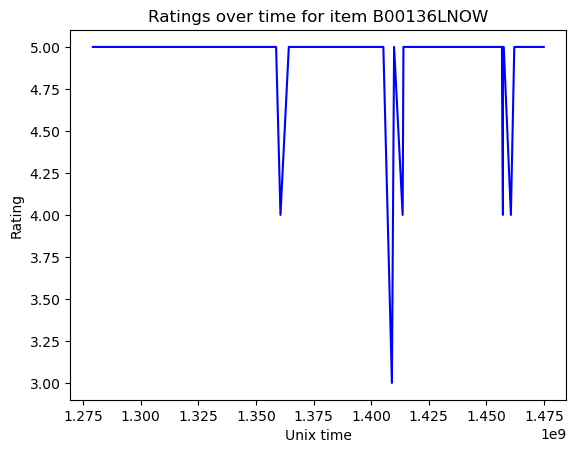

In [409]:
import random
id = random.randint(0, len(d_train)-1)
obj = d_train[id]
x= [info[0] for info in usersPerItem[obj['asin']]]
y=[info[2] for info in usersPerItem[obj['asin']]]

time_rating = sorted(list(zip(x,y)))

x = [t_r[0] for t_r in time_rating]
y = [t_r[1] for t_r in time_rating]

plt.plot(x,y,color='blue')
plt.ylabel("Rating")
plt.xlabel("Unix time")
print(obj)
plt.title(f"Ratings over time for item {obj['asin']}")
plt.show()


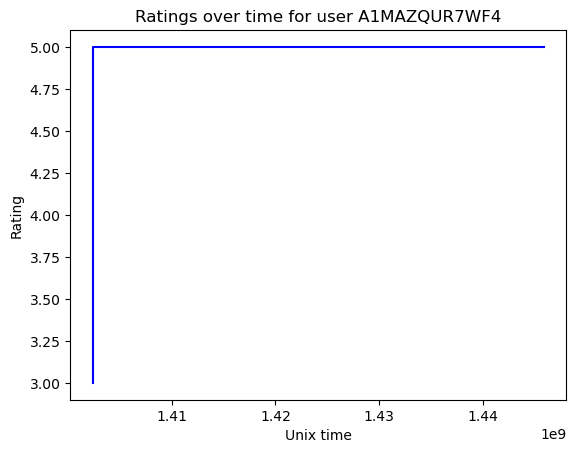

In [376]:
id = random.randint(0, len(d_train)-1)
obj = d_train[id]
x= [info[0] for info in itemsPerUser[obj['reviewerID']]]
y=[info[2] for info in itemsPerUser[obj['reviewerID']]]
z =[info[1] for info in itemsPerUser[obj['reviewerID']]]

time_rating = sorted(list(zip(x,y)))

x = [t_r[0] for t_r in time_rating]
y = [t_r[1] for t_r in time_rating]

plt.plot(x,y,color='blue')
plt.ylabel("Rating")
plt.xlabel("Unix time")
plt.title(f"Ratings over time for user {obj['reviewerID']}")
plt.show()


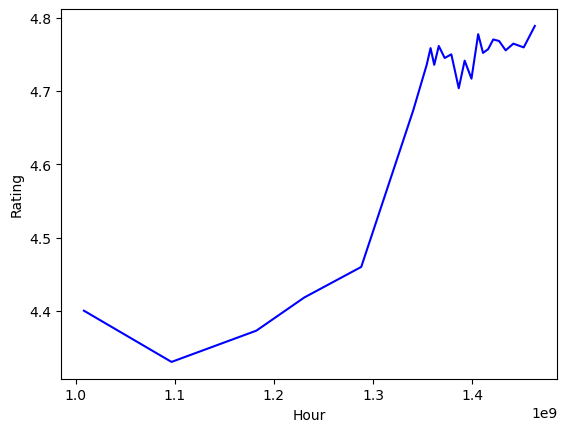

In [367]:
# # Sliding window(overview of the whole dataset)

ratingsTime = []
for d in d_train:
    ratingsTime.append((d['unixReviewTime'] ,d['overall']))


ratingsTime.sort()

wSize = 3600*2
xu = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings

# Use a dynamic-programming approach to build the sliding window
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []


for i in range(wSize,len(xu)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

# X and Y coordinates for plotting

X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

plt.plot(X[::wSize],Y[::wSize], color="blue")
plt.ylabel("Rating")
plt.xlabel("Hour")
#plt.title("Ratings over time (sliding windows)")
plt.show()

In [411]:
# # Autoregression
earliest = (float('inf'),0)
for event in events:
    if event[0] < earliest[0]:
        earliest = event


earliestTime = earliest[0]


# Count events by hour

hourly = defaultdict(list)

for event in events:
    t = event[0]
    hour = int(t - earliestTime) // (60*60)
    hourly[hour].append(event[1])


In [412]:
# Autoregressive feature representation. Here we don't include a bias term, though could easily include one.
ratingmean = sum(event[1] for event in events)/ len(events)
def feature(hour):
    previousHours = []
    # Features for last 12 hour, one day ago, one week ago, one month ago, 3 months ago
    for i in [12, 24, 24*7, 24*30, 24*90]:
        previousHour = hour - i
        avg = ratingmean
        avg_r = []
        for h in range(previousHour, hour):
            if hourly[h]:
                avg_r.append(sum(hourly[h])/len(hourly[h]))
        if not avg_r: previousHours += [ratingmean]
        else: previousHours += [sum(avg_r)/len(avg_r)]
            
    previousHours.append(1) #b
    return previousHours



X = [feature(int(event[0] - earliestTime) // (60*60)) for event in events]
y = [event[1] for event in events]


model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
theta = model.coef_


# The observation one day ago is the most predictive, followed by the observation from the previous week:

theta

array([-7.46166946e+09,  7.22408295e-04,  1.02604151e-01,  2.56383419e-01,
        5.60434103e-01,  3.49074308e+10])

In [416]:
print(X[:10])

[[4.678233333333333, 4.827586206896552, 4.755657083651049, 4.65413695031062, 4.706614471852769, 1], [4.678233333333333, 4.835051546391752, 4.759244939060458, 4.757893591612695, 4.748598706298169, 1], [4.678233333333333, 4.672727272727273, 4.726228891984458, 4.732692416337331, 4.735789520191646, 1], [4.678233333333333, 4.756944444444445, 4.742399375742006, 4.766029287427999, 4.726469553030921, 1], [4.678233333333333, 4.642857142857143, 4.618463385354142, 4.56804099741561, 4.451887127797031, 1], [4.678233333333333, 4.846153846153846, 4.545286459572174, 4.386275024539731, 4.39757372232968, 1], [4.678233333333333, 3.823529411764706, 4.529509985812506, 4.371061837212059, 4.428651484343053, 1], [4.678233333333333, 4.7368421052631575, 4.413809032384884, 4.353007164035252, 4.364429273351247, 1], [4.678233333333333, 4.65625, 4.616794465852023, 4.722663170703224, 4.753531245384211, 1], [4.678233333333333, 4.639344262295082, 4.8079391166876055, 4.80768671282, 4.772966823212481, 1]]


In [424]:
print(theta[-2])

0.560434103012085


In [413]:

earliest_test = (float('inf'),0)
for d in d_test:
    if d['unixReviewTime'] < earliest[0]:
        earliest_test = d['unixReviewTime']


earliestTime = earliest[0]
X_test = [feature(int(d['unixReviewTime'] - earliestTime) // (60*60)) for d in d_test]
y_test = [d['overall'] for d in d_test]

Y_naive = [ratingmean for d in d_test] 
Y_pred = numpy.dot(X_test,theta)
mse_1 = numpy.square(numpy.subtract(y_test,Y_pred)).mean()
mse_2 = numpy.square(numpy.subtract(y_test,Y_naive)).mean()

In [414]:
print(mse_1, mse_2)

1.3935822384550411 1.4117267211111106


In [176]:
ratingsTrain = [(d['reviewerID'], d['asin'], d['overall']) for d in d_train]
ratingsValid = [(d['reviewerID'], d['asin'], d['overall']) for d in d_valid]

In [182]:
def MSE(pred_rs, actual_rs):
    differences = [(pred_r - actual_r)**2 for pred_r, actual_r in zip(pred_rs,actual_rs)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(u, p) for u, p, r in ratingsTrain]
    cost = MSE(predictions, labels)
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(ratingsTrain)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for u, p, r in ratingsTrain:
        u,i = u, p
        pred = prediction(u, i)
        diff = pred - r
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return np.array(dtheta)

In [183]:
# Train
lamb = 1

labels = [d['overall'] for d in d_train]
users = list(itemsPerUser.keys())
items = list(usersPerItem .keys())
nUsers = len(users)
nItems = len(items)

alpha = ratingmean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)


scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, lamb))

(array([ 4.67829360e+00,  1.78777451e-06,  1.78777451e-06, ...,
         1.21259780e-05,  4.78413254e-06, -7.92115323e-06]),
 0.6633685920458418,
 {'grad': array([-2.66965508e-07,  7.31822156e-10,  7.31822156e-10, ...,
          9.16612979e-09,  8.21294488e-09,  5.06497478e-09]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

In [208]:
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

lambs = [10**i for i in range(-6, 2)]
mses = []
for lamb in lambs:
    scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                                 derivative, args = (labels, lamb))

    preds = []
    valid_labels  = []

    for u, p, r in ratingsValid:
        valid_labels.append(r)
        if u in userBiases and p in itemBiases:
            preds.append(prediction(u, p))
        elif u not in userBiases and p not in itemBiases:
            preds.append(ratingmean)
        elif u not in userBiases:
            preds.append(ratingmean + itemBiases[p])
        else:
            preds.append(ratingmean + userBiases[u])
        
    mses.append(MSE(preds, valid_labels))

validMSE = min(mses)
lamb = lambs[mses.index(validMSE)]

In [210]:
# add temporal bucket

In [266]:
hourly = defaultdict(list)

for event in events:
    t = event[0]
    hour = t // (60*60)
    hourly[hour].append(event[1])

In [271]:
def time_bias(time ,w, l):
    avg_r = []
    time_in_hour = time // (60*60)
    for h in range(0, w):
        hour =  time_in_hour-h
        if hourly[hour]:
            avg_r.append(sum(hourly[hour])/len(hourly[hour]))
    if avg_r:
        return l * (sum(avg_r)/len(avg_r) - ratingmean)
    else:
        return 0
    

In [272]:
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
window_size = [24, 24*3, 24*7, 24*30]
t_lambda = 0.1
lamb = 10**(0) #0.82...-5

ratingsValid = [(d['reviewerID'], d['asin'], d['overall'],d['unixReviewTime']) for d in d_valid]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                                 derivative, args = (labels, lamb))

preds = []
valid_labels  = []
mses = []

for w in window_size:
    for u, p, r, t in ratingsValid:
        valid_labels.append(r)
        t_b =  time_bias(t, w, t_lambda) 
        if u in userBiases and p in itemBiases:
            preds.append(prediction(u, p)+ t_b )
        elif u not in userBiases and p not in itemBiases:
            preds.append(ratingmean+t_b )
        elif u not in userBiases:
            preds.append(ratingmean + itemBiases[p]+ t_b )
        else:
            preds.append(ratingmean + userBiases[u]+ t_b )

    mses.append(MSE(preds, valid_labels))


In [273]:
print(mses)

[0.8636728959814862, 0.8635727924650317, 0.8636384726870203, 0.8636975401260495]


In [274]:
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
window_size = 24*3
t_lambda = [0.001, 0.01,0.1,1]

ratingsValid = [(d['reviewerID'], d['asin'], d['overall'],d['unixReviewTime']) for d in d_valid]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                                 derivative, args = (labels, lamb))

preds = []
valid_labels  = []
mses = []

for l in t_lambda:
    for u, p, r, t in ratingsValid:
        valid_labels.append(r)
        t_b =  time_bias(t, w, l) 
        if u in userBiases and p in itemBiases:
            preds.append(prediction(u, p)+ t_b )
        elif u not in userBiases and p not in itemBiases:
            preds.append(ratingmean+t_b )
        elif u not in userBiases:
            preds.append(ratingmean + itemBiases[p]+ t_b )
        else:
            preds.append(ratingmean + userBiases[u]+ t_b )

    mses.append(MSE(preds, valid_labels))


In [275]:
print(mses)

[0.8700563568234535, 0.8697647486511291, 0.8678014132874033, 0.8586678889971409]


In [291]:
userBiases = defaultdict(float)
itemBiases = defaultdict(float)
window_size = [12, 24, 24*7]
t_lambda = [0.001, 0.01,0.1,1]
w = 24*3
l = 0.5
lamb = 10**(-5)

ratingsTest = [(d['reviewerID'], d['asin'], d['overall'],d['unixReviewTime']) for d in d_test]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                                 derivative, args = (labels, lamb))


(array([ 4.69362089,  0.18348985,  0.18348985, ...,  0.08320434,
         0.07257153, -0.09920159]),
 0.3021719597911293,
 {'grad': array([-2.07258961e-07,  6.06884249e-08,  6.06884249e-08, ...,
          6.56378990e-08, -1.30446145e-08, -6.15841343e-08]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 288,
  'nit': 247,
  'warnflag': 0})

In [325]:
#without time bias
for u, p, r, t in ratingsTest:
    test_labels.append(r)
    if u in userBiases and p in itemBiases:
        preds.append(prediction(u, p))
    elif u not in userBiases and p not in itemBiases:
        preds.append(ratingmean)
    elif u not in userBiases:
        preds.append(ratingmean + itemBiases[p])
    else:
        preds.append(ratingmean + userBiases[u])
mse = MSE(preds, test_labels)
print(mse) 
print(accuracy(preds, test_labels))

1.3687254958387092
1.0


In [326]:
# with time bias
preds = []
test_labels  = []
mses = []
w = 24*7*4
l = 1

for u, p, r, t in ratingsTest:
    test_labels.append(r)
    t_b =  time_bias(t, w, l) 
    if u in userBiases and p in itemBiases:
        preds.append(prediction(u, p)+ t_b )
    elif u not in userBiases and p not in itemBiases:
        preds.append(ratingmean+t_b )
    elif u not in userBiases:
        preds.append(ratingmean + itemBiases[p]+ t_b )
    else:
        preds.append(ratingmean + userBiases[u]+ t_b )

mse = MSE(preds, test_labels)

In [327]:
print(mse)
print(accuracy(preds, test_labels))

1.3590447518327216
1.0


100710 7580


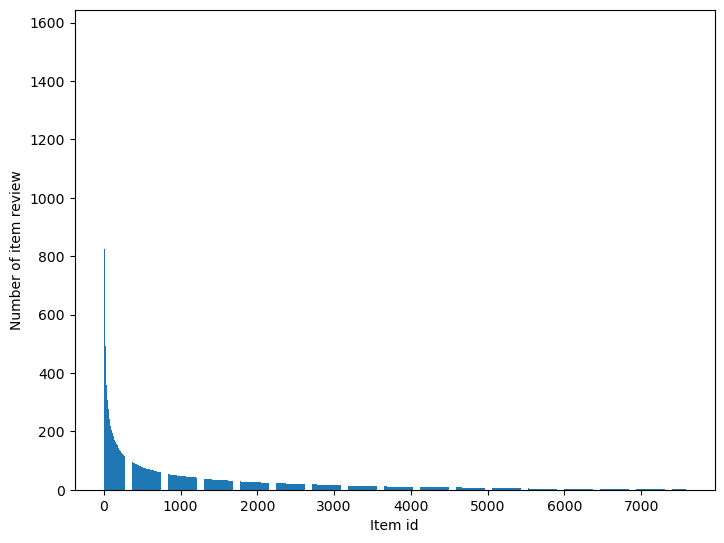

In [14]:


users = list(itemsPerUser.keys())
items = list(usersPerItem .keys())
nUsers = len(users)
nItems = len(items)

print(nUsers, nItems)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

nums = [len(usersPerItem[item]) for item in items]

res = sorted(list(zip(nums, items)), reverse = True)
items_1000 = range(0, len(res))
nums_1000 = [x[0] for x in res]

plt.ylabel("Number of item review")
plt.xlabel("Item id")
ax.bar(items_1000,nums_1000)
plt.show()